In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./data/train.csv',
                dtype  = {'Semana': 'int32',
                'Producto_ID':'int32',
                'Venta_hoy':'float32',
                'Venta_uni_hoy': 'int32',
                'Dev_uni_proxima':'int32',
                'Dev_proxima':'float32',
                'Demanda_uni_equil':'int32'})

In [3]:
products  =  pd.read_csv('./data/producto_tabla.csv')
products['short_name'] = products.NombreProducto.str.extract('^(\D*)')
products['brand'] = products.NombreProducto.str.extract('^.+\s(\D+) \d+$')
w = products.NombreProducto.str.extract('(\d+)(Kg|g)')
products['weight'] = w[0].astype('float')*w[1].map({'Kg':1000, 'g':1})
vol = products.NombreProducto.str.extract('(\d+)(ml)')
products['volume'] = vol[0].astype('float')
products['pieces'] =  products.NombreProducto.str.extract('(\d+)p ').astype('float')

In [4]:
from nltk.corpus import stopwords
products['short_name_processed'] = (products['short_name']
                                        .map(lambda x: " ".join([i for i in x.lower()
                                        .split() if i not in stopwords.words("spanish")])))

In [5]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("spanish")
products['short_name_processed'] = (products['short_name_processed']
                                    .map(lambda x: " ".join([stemmer.stem(i) for i in x.lower().split()])))

In [83]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None, 
                             preprocessor = None,
                             stop_words = None,
                             max_features = 1000) 

product_bag_words = vectorizer.fit_transform(products.short_name_processed).toarray()

In [84]:
product_bag_words = pd.concat([products.Producto_ID, 
                               pd.DataFrame(product_bag_words, 
                               columns= vectorizer.get_feature_names(), index = products.index)], axis=1)

In [80]:
from sklearn.metrics.pairwise import cosine_distances

In [90]:
product_bag_words.drop('Producto_ID',axis=1).values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [92]:
distance_matrix = cosine_distances(product_bag_words.drop('Producto_ID',axis=1).values)

In [139]:
from sklearn.cluster import DBSCAN
db_cl = DBSCAN(eps=0.5,min_samples=3,metric='precomputed',algorithm='auto', leaf_size=30, p=None)

In [140]:
xx = db_cl.fit_predict(distance_matrix)

In [141]:
print max(xx)
print np.sum(xx == -1)

69
239


In [144]:
df.shape

(74180464, 13)

In [ ]:
# train.csv — the training set
# test.csv — the test set
# sample_submission.csv — a sample submission file in the correct format
# cliente_tabla.csv — client names (can be joined with train/test on Cliente_ID)
# producto_tabla.csv — product names (can be joined with train/test on Producto_ID)
# town_state.csv — town and state (can be joined with train/test on Agencia_ID)


# Semana — Week number (From Thursday to Wednesday)
# Agencia_ID — Sales Depot ID
# Canal_ID — Sales Channel ID
# Ruta_SAK — Route ID (Several routes = Sales Depot)
# Cliente_ID — Client ID
# NombreCliente — Client name
# Producto_ID — Product ID
# NombreProducto — Product Name
# Venta_uni_hoy — Sales unit this week (integer)
# Venta_hoy — Sales this week (unit: pesos)
# Dev_uni_proxima — Returns unit next week (integer)
# Dev_proxima — Returns next week (unit: pesos)
# Demanda_uni_equil — Adjusted Demand (integer) (This is the target you will predict)

#The demand for a product in a certain week is defined as the sales this week subtracted by the return next week.

In [6]:
clients = pd.read_csv('./data/cliente_tabla.csv')
towns = pd.read_csv('./data/town_state.csv')

In [59]:
clients

,Cliente_ID,NombreCliente
0,0,SIN NOMBRE
1,1,OXXO XINANTECATL
2,2,SIN NOMBRE
3,3,EL MORENO
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT
5,4,SDN SER DE ALIM CUERPO SA CIA DE INT
6,5,LA VAQUITA
7,6,LUPITA
8,7,I M EL GUERO
9,8,MINI SUPER LOS LUPES


In [61]:
towns['postcode'] = towns.Town.map(lambda x: x[:7])

In [77]:
# use location and client with bayesian classifier / logistic / 
df

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,return_unit_price,sales_unit_price
0,3,1110,7,3301,15766,1212,3,25.139999,0,0.000000,3,8.380000,NaN
1,3,1110,7,3301,15766,1216,4,33.520000,0,0.000000,4,8.380000,NaN
2,3,1110,7,3301,15766,1238,4,39.320000,0,0.000000,4,9.830000,NaN
3,3,1110,7,3301,15766,1240,4,33.520000,0,0.000000,4,8.380000,NaN
4,3,1110,7,3301,15766,1242,3,22.920000,0,0.000000,3,7.640000,NaN
5,3,1110,7,3301,15766,1250,5,38.200001,0,0.000000,5,7.640000,NaN
6,3,1110,7,3301,15766,1309,3,20.280001,0,0.000000,3,6.760000,NaN
7,3,1110,7,3301,15766,3894,6,56.099998,0,0.000000,6,9.349999,NaN
8,3,1110,7,3301,15766,4085,4,24.600000,0,0.000000,4,6.150000,NaN
9,3,1110,7,3301,15766,5310,6,31.680000,0,0.000000,6,5.280000,NaN


In [71]:
clients['NameRoot'] = clients.NombreCliente.map(lambda x: ''.join(i for i in x.split()[0] if not i.isdigit()))

In [ ]:
df.merge(clients,on)

In [33]:
# Use stacking on different portion of the dataset
df.Producto_ID.nunique()

1799

In [27]:
# perhaps it's better to predict sales and return prices
df['return_unit_price'] = df.Venta_hoy / df.Venta_uni_hoy
df['sales_unit_price'] = df.Dev_proxima / df.Dev_uni_proxima

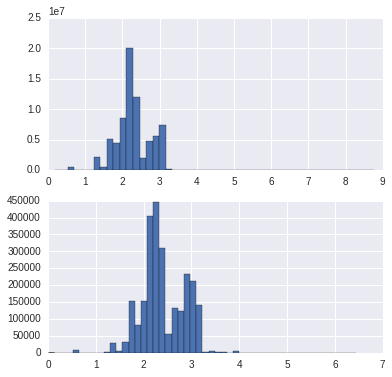

In [29]:
# unit price
plt.figure(figsize=(6,6))
plt.subplot(211)
bins = plt.hist(np.log1p(df.return_unit_price.dropna().values),50)
plt.subplot(212)
bins = plt.hist(np.log1p(df.sales_unit_price.dropna().values),50)

In [30]:
df['diff_unit_price'] = df.sales_unit_price - df.return_unit_price

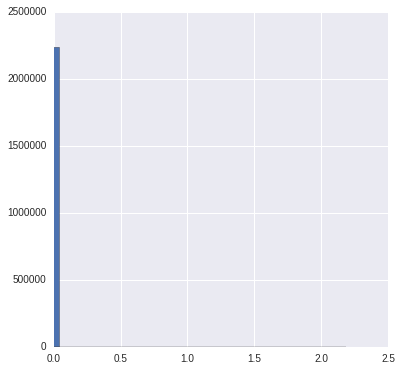

In [44]:
plt.figure(figsize=(6,6))
bins = plt.hist(np.log1p(abs(df.diff_unit_price.dropna().values)),50)

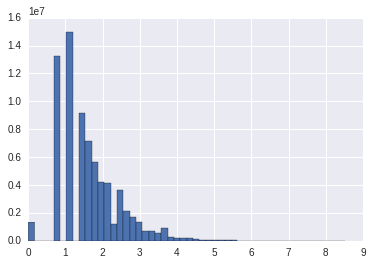

In [14]:
# cannot use product_id as there are new products in the test set
import matplotlib.pyplot as plt
%matplotlib inline
bins = plt.hist(np.log1p(df.Demanda_uni_equil),50)

In [46]:
df.Canal_ID.unique()

array([ 7,  8, 11,  1,  4,  2,  6,  5,  9])

In [53]:
df.Ruta_SAK.value_counts()[:500]

1201    461918
1203    438474
1202    427767
1204    418744
1205    409597
1206    391245
1207    383959
1213    383761
1208    369824
1212    359986
1103    357276
1221    355455
1101    352677
1102    350716
1214    346421
1211    342822
1104    330540
1215    323577
1210    323423
1222    319514
1209    315325
1216    303376
1223    300478
1224    298955
1105    298796
1225    285764
2802    280893
1217    280339
1220    276381
1106    270827
         ...  
4421     47008
2128     46622
4506     46565
2150     46361
2061     46327
2031     45945
2136     45403
1291     45111
2057     44988
3903     44958
3904     44952
1076     44899
2055     44454
2127     44432
2056     43793
2034     43422
1077     43406
1627     43156
4420     43146
4418     42921
4102     42829
1176     42786
1628     42552
4505     42478
2137     42190
5006     42123
2864     42087
2163     41998
1432     41840
5501     41479
Name: Ruta_SAK, dtype: int64

In [35]:
test_set = pd.read_csv('./data/test.csv')

In [48]:
Product_avg_price = []
Product_avg_unit = []
for x in df.Producto_ID.unique():
    Product_avg_price.append(df.loc[(df.Producto_ID == x),'sales_unit_price'].mean())
    Product_avg_unit.append(df.loc[(df.Producto_ID == x),'Venta_uni_hoy'].mean())

(array([ 859.,  488.,   95.,   46.,   16.,    4.,    9.,    4.,    0.,
           3.,    1.,    2.,    1.,    5.,    0.,    0.,    0.,    1.,
           0.,    0.,    0.,    0.,    0.,    0.,    2.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    1.]),
 array([  9.99999978e-03,   1.26498000e+01,   2.52896000e+01,
          3.79294000e+01,   5.05692000e+01,   6.32090000e+01,
          7.58488000e+01,   8.84886000e+01,   1.01128400e+02,
          1.13768200e+02,   1.26408000e+02,   1.39047800e+02,
          1.51687600e+02,   1.64327400e+02,   1.76967200e+02,
          1.89607000e+02,   2.02246800e+02,   2.14886600e+02,
          2.27526400e+02,   2.40166200e+02,   2.52806000e+02,
          2.65445800e+02,   2.78085600e+02,   2.90725400e+02,
          3.03365200e+02,   3.16005000e+02,   3.28644800e+02,
          3.41284600e+02,   3.53924400e+02

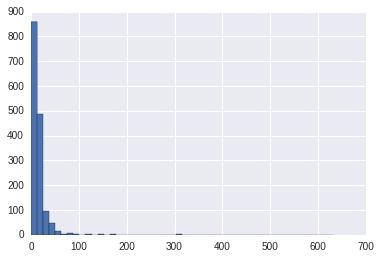

In [39]:
xx = np.array(Product_avg_price.values())
plt.hist(xx[~np.isnan(xx)],50)

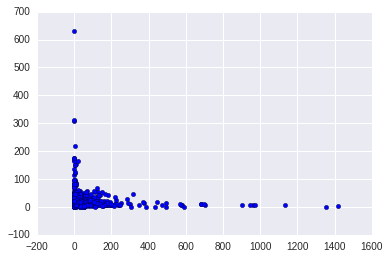

In [49]:
plt.scatter(Product_avg_unit,Product_avg_price)